In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO
import tensorflow as tf
import tensorboard
import os
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import warnings
from ConvNetwork import CNN
warnings.filterwarnings("ignore")

# Background

Our team wants to build an automatic pipeline to distinguish between seven different skin lesion categories using only skin images: (1) actinic keratoses and intraepithelial carcinoma, (2) basal cell carcinoma, (3) benign keratosis-like lesions, (4) dermatofibroma, (5) melanoma, (6) melanocytic nevi, and (7) vascular lesions. As part of an international collaboration, our team has collected 10,015 images that have been manually labeled with the lesion category. The dataset has already been divided between training, validation and test image groups.

# Goals
To build and evaluate a convolutional neural network that can automatically identify the type of skin lesion from skin images.
1. Design your own architecture and justify its components (width, depth, convolutions, activations and any other operations)
2. Justify your choices of loss function and optimizer  
3. Provide the curves (preferably from Tensorboard) with the evolution during training of the training and validation losses and accuracies.  
4. Evaluate the performance using the test dataset by providing the overall accuracy of the model, and the individual sensitivity and specificity (and any other metrics that you may consider relevant) on every class. Interpret your results.  

# Data Pre-Processing

In [2]:
# Import data
nChannels = INFO['dermamnist']['n_channels']
nClasses = len(INFO['dermamnist']['label'])
DataClass = medmnist.DermaMNIST

# Transforming images to Torch Tensor and normalizing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1])])

# Obtaining the training, validation and test datasets
trainingData = DataClass(split='train', transform=data_transform, download=True)
validationData = DataClass(split='val', transform=data_transform, download=True)
testData = DataClass(split='test', transform=data_transform, download=True)

Using downloaded and verified file: /Users/bgraham/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/bgraham/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/bgraham/.medmnist/dermamnist.npz


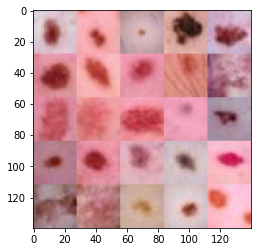

In [3]:
# This code will show a preview of the images
a = trainingData.montage(length=5)
plt.imshow(a)
plt.show()

# Configuring the batch size and creating data loaders
batchSize = 100
trainLoader = data.DataLoader(dataset=trainingData, batch_size=batchSize, shuffle=True)
validationLoader = data.DataLoader(dataset=validationData, batch_size=batchSize, shuffle=True)
testLoader = data.DataLoader(dataset=testData, batch_size=batchSize, shuffle=False)

# EDA
## Class Imbalance in the Targets
Class imbalance is evident in the targets, which should be accounted for in our model. Melanocytic nevi is by far the most prevalent condition. Target classes are at similar prevelance across all three data sets which is convenient.

In [4]:
# Check class balance
classLabels = INFO['dermamnist']['label']
trainingTargets = [targets[0] for inputs, targets in trainingData]
validationTargets = [targets[0] for inputs, targets in validationData]
testTargets = [targets[0] for inputs, targets in testData]

In [5]:
classLabels

{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}

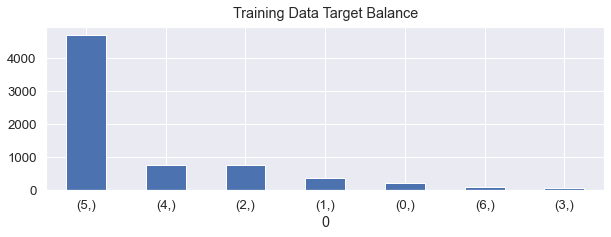

In [6]:
sns.set(font_scale=1.2)
pd.DataFrame(trainingTargets).value_counts().plot(kind='bar', figsize=(10, 3), rot=0)
plt.title("Training Data Target Balance", y=1.02);

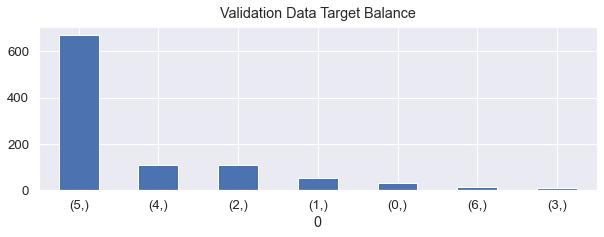

In [7]:
sns.set(font_scale=1.2)
pd.DataFrame(validationTargets).value_counts().plot(kind='bar', figsize=(10, 3), rot=0)
plt.title("Validation Data Target Balance", y=1.02);

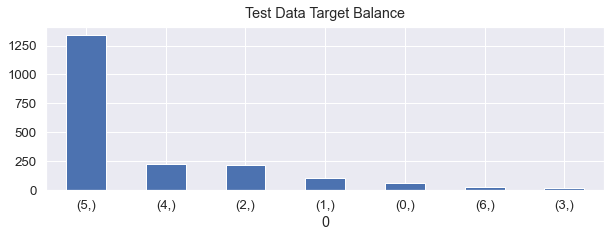

In [8]:
sns.set(font_scale=1.2)
pd.DataFrame(testTargets).value_counts().plot(kind='bar', figsize=(10, 3), rot=0)
plt.title("Test Data Target Balance", y=1.02);

# CNN
## Model Architecture
I ended up trying a ton of different architecture configurations and couldn't get the performance to surpass this. The architecture that I decided on somewhat resembles the VGG architecture. I wanted to use small kernal sizes (3x3) and stride sizes in the convolutional layers to preserve spatial resolution. I used ReLU activation functions, batch normalization steps, and max pooling steps (every other convolutional layer) with small kernel and stride sizes. I tried to increase output channel size in the architecture up to 128 channels. No padding was used until the final convolutional layer since there is no real point for padding in this problem. Padding was only used in the final convolutional layer to make the in/out numbers work. The model seemed to not converge when using a learning rate of 1E-3, so I decided tried to include a learning decay attribute (i.e., start with a larger LR of 0.01 and shrink the learning rate to 0.001 after the first 5 epochs), but this returned poor performance for some reason. To help the model reach convergence I therefore increased the number of epochs to 200; this doesn't necessarily help with the apparent overfitting problem however. I opted for the Adam optimizer since it is widely used for its simplicity, it is computational efficient, and it seems to be used commonly for these types of applications. I used cross entropy loss which seems very common for these multiclass classification problems. In the loss I specify an argument that applies class weights; this helps alleviate the class imbalance problem. Softmax is used during the prediction stage to return class assignment probabilities that add to 1.

## Training

In [9]:
# Remove logs from previous runs
os.system('rm -rf runs/*')

# Load the tensorboard notebook extension
%load_ext tensorboard

In [10]:
# Calculate class weights for loss
classWeights = compute_class_weight(
    class_weight='balanced', classes=np.unique(trainingTargets), y=np.asarray(trainingTargets))
classWeights = torch.tensor(classWeights, dtype=torch.float)

In [12]:
# Initialize and train model
model = CNN(nChannels, nClasses, learningRate=1E-3, nEpochs=200)
model.trainModel(trainLoader, validationLoader, classWeights=classWeights)

Epoch: 0, LR: 0.001
Epoch: 1, LR: 0.001
Epoch: 2, LR: 0.001
Epoch: 3, LR: 0.001
Epoch: 4, LR: 0.001
Epoch: 5, LR: 0.001
Epoch: 6, LR: 0.001
Epoch: 7, LR: 0.001
Epoch: 8, LR: 0.001
Epoch: 9, LR: 0.001
Epoch: 10, LR: 0.001
Epoch: 11, LR: 0.001
Epoch: 12, LR: 0.001
Epoch: 13, LR: 0.001
Epoch: 14, LR: 0.001
Epoch: 15, LR: 0.001
Epoch: 16, LR: 0.001
Epoch: 17, LR: 0.001
Epoch: 18, LR: 0.001
Epoch: 19, LR: 0.001
Epoch: 20, LR: 0.001
Epoch: 21, LR: 0.001
Epoch: 22, LR: 0.001
Epoch: 23, LR: 0.001
Epoch: 24, LR: 0.001
Epoch: 25, LR: 0.001
Epoch: 26, LR: 0.001
Epoch: 27, LR: 0.001
Epoch: 28, LR: 0.001
Epoch: 29, LR: 0.001
Epoch: 30, LR: 0.001
Epoch: 31, LR: 0.001
Epoch: 32, LR: 0.001
Epoch: 33, LR: 0.001
Epoch: 34, LR: 0.001
Epoch: 35, LR: 0.001
Epoch: 36, LR: 0.001
Epoch: 37, LR: 0.001
Epoch: 38, LR: 0.001
Epoch: 39, LR: 0.001
Epoch: 40, LR: 0.001
Epoch: 41, LR: 0.001
Epoch: 42, LR: 0.001
Epoch: 43, LR: 0.001
Epoch: 44, LR: 0.001
Epoch: 45, LR: 0.001
Epoch: 46, LR: 0.001
Epoch: 47, LR: 0.001
Ep

In [14]:
%tensorboard --logdir=runs

## Training Comments
Even with 200 epochs it doesn't appear like the model is fully converging. Additionally, the validation accuracy is much below the training accuracy which suggests overfitting. I wish I could figure out an optimal learning decay; this would, in theory, help alleviate both of my problems.

## Test

In [17]:
y_true, y_score, y_pred = model.predict(testLoader)
correct = (y_true == y_pred).float()
testAccuracy = correct.sum() / correct.numel()
testAccuracy

tensor(0.6963)

In [40]:
from sklearn.metrics import precision_recall_fscore_support
target_names = list(classLabels.values())
results = []
for class_ in range(0, 7):
    prec, recall, _, _ = precision_recall_fscore_support(
        np.array(y_true) == class_,
        np.array(y_pred) == class_,
        pos_label = True, average = None)
    results.append([class_, round(recall[1], 2), round(recall[0], 2)])
resultsDF = pd.DataFrame(results, columns = ['Class', 'Sensitivity', 'Specificity'])
resultsDF.index = list(classLabels.values())
resultsDF

,Class,Sensitivity,Specificity
actinic keratoses and intraepithelial carcinoma,0,0.44,0.98
basal cell carcinoma,1,0.48,0.96
benign keratosis-like lesions,2,0.52,0.90
dermatofibroma,3,0.26,0.99
melanoma,4,0.42,0.92
melanocytic nevi,5,0.81,0.78
vascular lesions,6,0.83,0.99


## Discussion
The overall accuracy of the model is 69.63%. Sensitivity (recall) and specificity are shown for each class in the table above. Sensitivities are balanced at an acceptable level, although we would like to see some improvements here. We achieve the greatest sensitivity in class 6, which is interesting since it is one of the smallest classes. The next best class in terms of sensitivity is class 5 (melanocytic nevi), which happens to be the majority class. The worst class in terms of sensityivity is class 3, which makes sense since it is the least represented class in each data set split. A relatively low specificity (but high sensitivity) in the majority class (class 5) suggests that the model is predicting class 5 at a high clip (eager to predict this class), and to a fault; there are considerably more FPs for this class than others. Meanwhile, the minority classes have high specificity suggesting when they are predicted they are usually correct. Balancing these results would be ideal when considering model improvements.